# EDA Notebook 01
We will be using this notebook for preliminary EDA to understand the data better before we start fitting models and analyzing results


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plots
sns.set_style('darkgrid')


In [2]:
# Read in data
df = pd.read_csv('../data/heart_failure_clinical_records_dataset.csv')

In [3]:
print(df.head(1))
print('='*100)
print(df.info())
print('='*100)
print(df.describe())
print('='*100)
# Check for missing values
print(df.isnull().sum())



    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1   265000.0               1.9           130    1   

   smoking  time  DEATH_EVENT  
0        0     4            1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 n

### Clean Data (some Preprocessing)
Note: we should still use non scaled (raw) data for initial EDA


In [4]:
continuous_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
categorical_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

In [5]:
# Remove Outliers
quantile_1 = df[continuous_features].quantile(0.25)
quantile_3 = df[continuous_features].quantile(0.75)
iqr = quantile_3 - quantile_1
lower_bound = quantile_1 - 1.5 * iqr
upper_bound = quantile_3 + 1.5 * iqr

outliers = (df[continuous_features] < lower_bound) | (df[continuous_features] > upper_bound)

print("Outliers: ")
outliers.sum()

Outliers: 


age                          0
creatinine_phosphokinase    29
ejection_fraction            2
platelets                   21
serum_creatinine            29
serum_sodium                 4
time                         0
dtype: int64

In [6]:
rows_w_outliers = outliers.any(axis=1)
df_clean = df[~rows_w_outliers] # return dataframe without outliers

df_clean.shape
df = df_clean.copy()

In [7]:
# save cleaned data to csv (commented out to avoid overwriting)
# df.to_csv('../data/heart_failure_clinical_records_dataset_cleaned.csv', index=False)


There are not any missing values, we should be okay to proceed to EDA

### Explore DEATH_EVENT

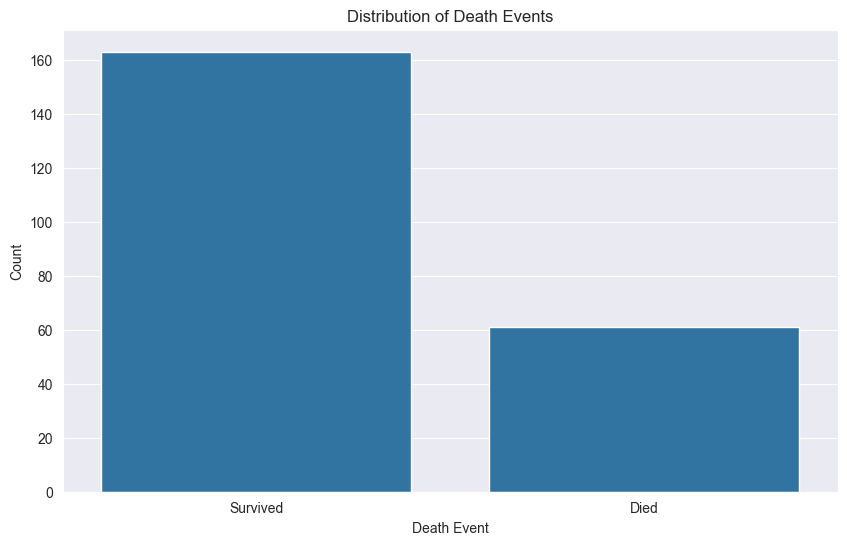

Percentage of DEATH_EVENT:
DEATH_EVENT
0    72.767857
1    27.232143
Name: proportion, dtype: float64

Imbalance ratio: 2.67


In [8]:
# Explore death event distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='DEATH_EVENT', data=df)
plt.title('Distribution of Death Events')
plt.xlabel('Death Event')
plt.ylabel('Count')
plt.xticks([0, 1], ['Survived', 'Died'])
plt.show()
print("Percentage of DEATH_EVENT:")
print(df['DEATH_EVENT'].value_counts(normalize=True)*100)
imbalance_ratio = df['DEATH_EVENT'].value_counts(normalize=True)[0] / df['DEATH_EVENT'].value_counts(normalize=True)[1]
print(f"\nImbalance ratio: {imbalance_ratio:.2f}")



The dataset shows moderate class imbalance, with approximately 68% survival rate (203 patients) and 32% mortality rate (96 patients). The imbalance ratio is about 2:1, which is moderate - not severe enough to require aggressive resampling, but we should consider using stratified cross-validation and monitoring precision/recall metrics in addition to accuracy.

In [9]:
# Death Rate between Male and Female:

male = df.loc[df['sex'] == 1, 'DEATH_EVENT']
female = df.loc[df['sex'] == 0, 'DEATH_EVENT']

print("Male Death Rate", male.mean())
print("Female Death Rate", female.mean())

Male Death Rate 0.2847222222222222
Female Death Rate 0.25


### Univariate EDA

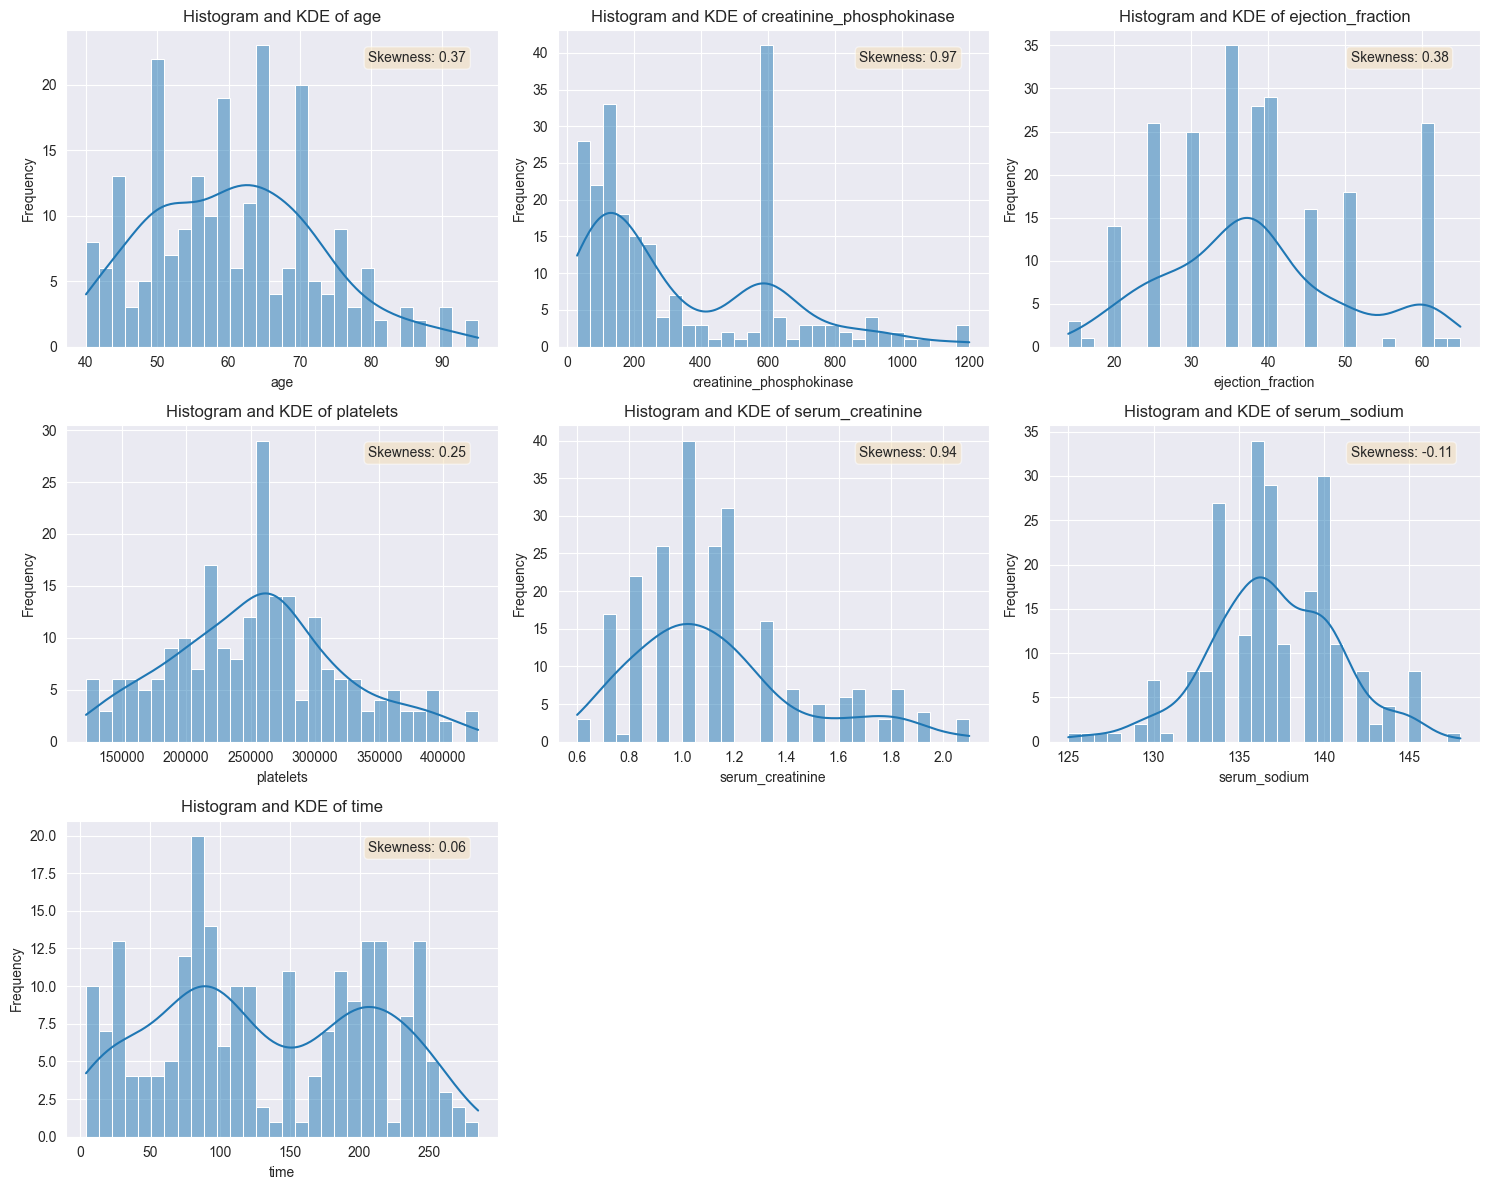

In [10]:
# Create histograms and KDE for continuous features
fix, axis = plt.subplots(3,3, figsize=(15,12))
axis = axis.flatten()

for i, feature in enumerate(continuous_features):
    sns.histplot(
        df[feature], 
        ax=axis[i], 
        kde=True, 
        bins=30)
    axis[i].set_title(f'Histogram and KDE of {feature}')
    axis[i].set_xlabel(feature)
    axis[i].set_ylabel('Frequency')

    skew = df[feature].skew()
    axis[i].text(0.7, 0.9, f'Skewness: {skew:.2f}', 
        transform=axis[i].transAxes, 
        bbox=dict(boxstyle='round',facecolor='wheat',alpha=0.5))

axis[-2].remove()
axis[-1].remove()
plt.tight_layout()
plt.show()

### Analysis of Feature Distributions (After Outlier Removal)

### Skewness Interpretation

**Highly Symmetric (|skew| < 0.5):**
- **time** (skew = 0.06): Nearly perfectly symmetric distribution
- **serum_sodium** (skew = -0.11): Almost perfectly symmetric, well-centered distribution
- **platelets** (skew = 0.25): Very symmetric, minimal skew
- **age** (skew = 0.37): Slight right skew, relatively normal distribution centered around 60 years
- **ejection_fraction** (skew = 0.38): Slight right skew, appears somewhat uniform with potential subgroups (normal vs reduced ejection fraction)

**Moderately Skewed (0.5 < |skew| < 2):**
- **serum_creatinine** (skew = 0.94): Moderate right skew, most patients have normal kidney function with some elevated values
- **creatinine_phosphokinase** (skew = 0.97): Moderate right skew, previously highly skewed but much improved after outlier removal

### Key Observations

**Impact of Outlier Removal:**
1. **Dramatic improvement in skewness**: CPK and serum_creatinine went from extremely skewed (4.46) to moderately skewed (~0.95), making them much more suitable for parametric models
2. **Better normality**: Most features now fall within the fairly symmetric range (|skew| < 0.5), which is ideal for many machine learning algorithms
3. **Preserved clinical validity**: Distributions still reflect real medical patterns without extreme outliers

**Remaining Characteristics:**
- **Scale differences**: Features still span different ranges (will require normalization/standardization for modeling)
- **Potential subgroups**: Ejection fraction still shows evidence of two patient populations (normal vs reduced EF)
- **Data quality**: After outlier removal, the dataset is cleaner and more suitable for modeling while maintaining clinical relevance


### Bivariate EDA: Features vs Target (DEATH_EVENT)


/var/folders/s_/q9c9gdyj1l3f0bl9d9knwkjr0000gn/T/ipykernel_9240/2286674102.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='DEATH_EVENT', y=feature, ax=axes[i], palette='muted', inner='quartile')
/var/folders/s_/q9c9gdyj1l3f0bl9d9knwkjr0000gn/T/ipykernel_9240/2286674102.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Survived', 'Died'])
/var/folders/s_/q9c9gdyj1l3f0bl9d9knwkjr0000gn/T/ipykernel_9240/2286674102.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='DEATH_EVENT', y=feature, ax=axes[i], palette='muted', inner='quartile')
/var/folders

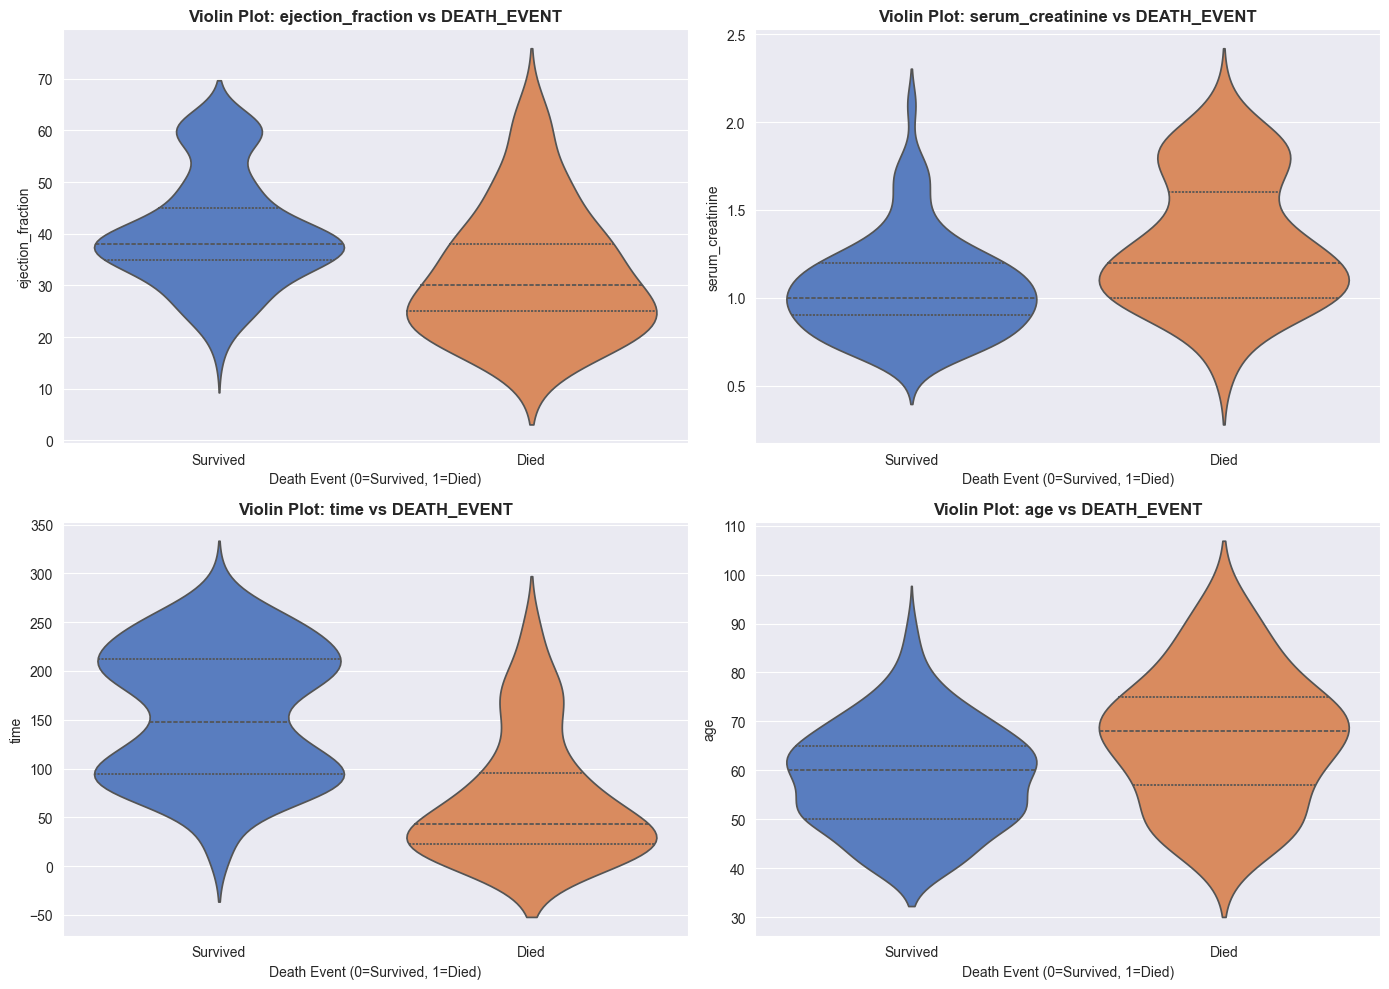

In [11]:
# Violin plots for key continuous features (showing distribution shape)
key_features = ['ejection_fraction', 'serum_creatinine', 'time', 'age']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    sns.violinplot(data=df, x='DEATH_EVENT', y=feature, ax=axes[i], palette='muted', inner='quartile')
    axes[i].set_title(f'Violin Plot: {feature} vs DEATH_EVENT', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Death Event (0=Survived, 1=Died)')
    axes[i].set_ylabel(feature)
    axes[i].set_xticklabels(['Survived', 'Died'])

plt.tight_layout()
plt.show()


### Analysis
#### Ejection Fraction:
Survived group:  

- Centered around 40–50%, with many patients between 35–60%.  
- Distribution is wider (more patients with moderately healthy function).  

Dead group:  

- Strongly centered near 25–30%.  
- Very few patients with healthy ejection fractions (>40%).  
- Shape is narrow and skewed toward low EF.  

*Conclusion:*  
Lower ejection fraction is associated with death.  
This feature will likely be one of the top predictors.  

#### Serum Creatinine

Survived:

- Most patients have creatinine around 0.8–1.2 mg/dL (normal range).
- Very tight distribution.

Died:

- Distribution shifts upward: many near 1.5–2.0 mg/dL.
- Much wider spread; more high-creatinine outliers.

*Conclusion:*  
Higher serum creatinine (worse kidney function) is strongly associated with death.
Expecting this feature to rank highly in model importance.

#### Age
- Patients who died tend to be older, which implies that age is a meaninful risk factor


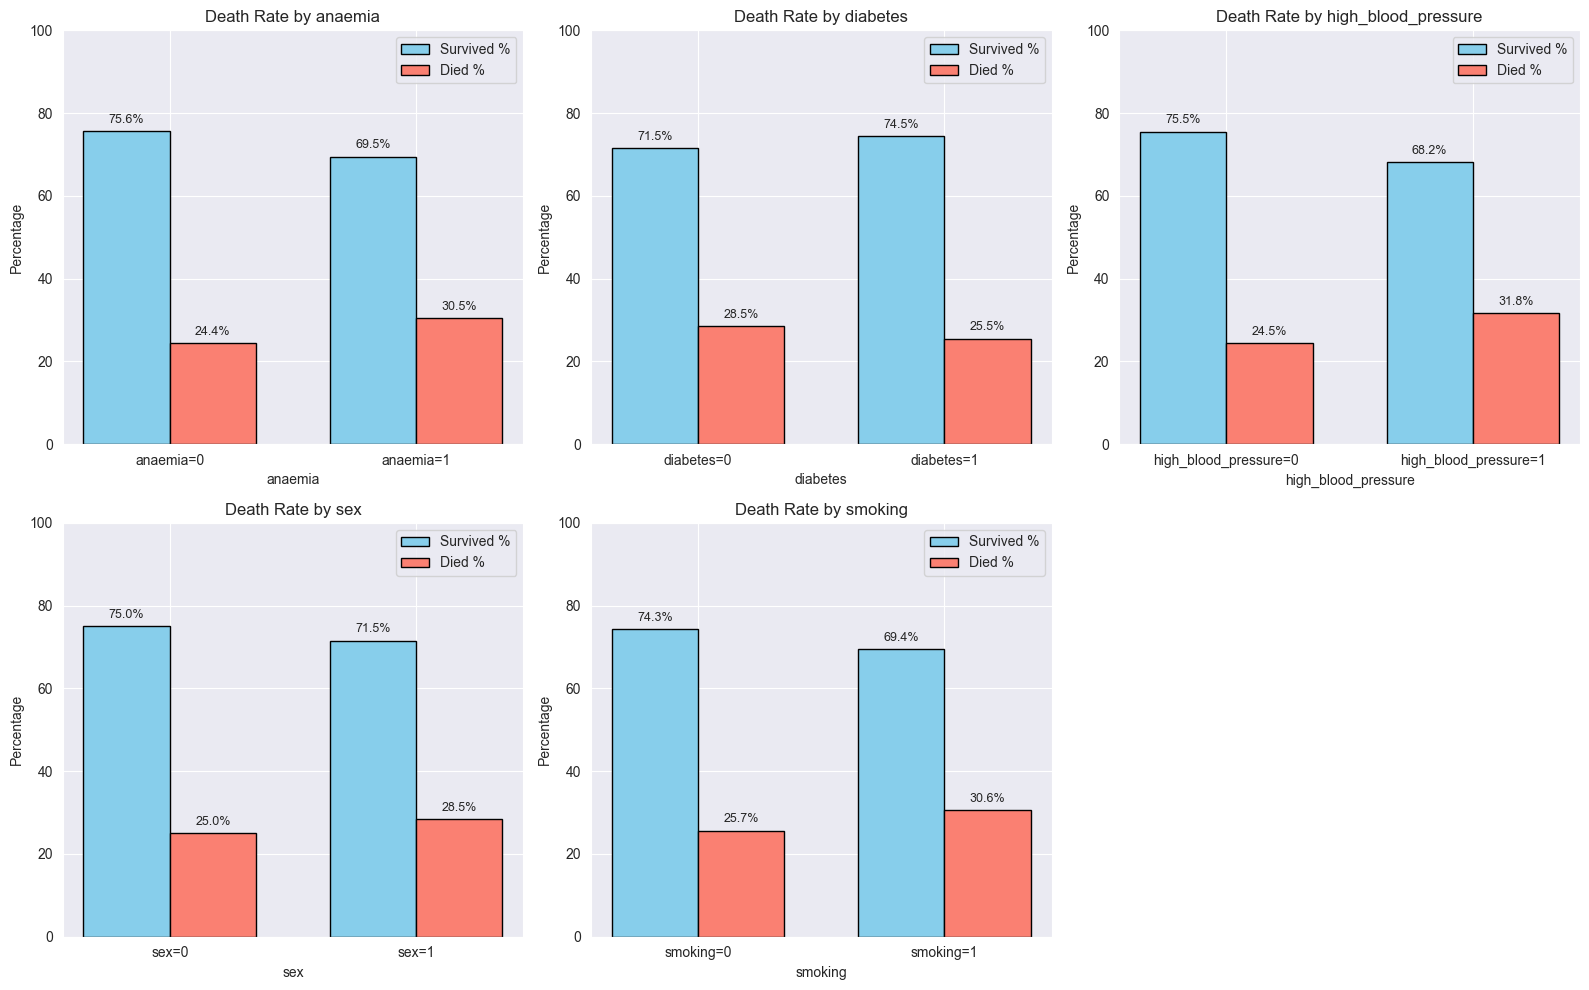

In [12]:
# Grouped bar charts: Death rate by categorical features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    death_rate = df.groupby(feature)['DEATH_EVENT'].agg(['sum', 'count', 'mean'])
    death_rate['survival_rate'] = 1 - death_rate['mean']
    
    x = death_rate.index.astype(str)
    width = 0.35
    x_pos = np.arange(len(x))
    
    axes[i].bar(x_pos - width/2, death_rate['survival_rate'] * 100, width, 
                label='Survived %', color='skyblue', edgecolor='black')
    axes[i].bar(x_pos + width/2, death_rate['mean'] * 100, width, 
                label='Died %', color='salmon', edgecolor='black')
    
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Percentage')
    axes[i].set_title(f'Death Rate by {feature}')
    axes[i].set_xticks(x_pos)
    axes[i].set_xticklabels([f'{feature}={val}' for val in x])
    axes[i].legend()
    axes[i].set_ylim(0, 100)
    
    for j, (surv, died) in enumerate(zip(death_rate['survival_rate'] * 100, death_rate['mean'] * 100)):
        axes[i].text(j - width/2, surv + 2, f'{surv:.1f}%', ha='center', fontsize=9)
        axes[i].text(j + width/2, died + 2, f'{died:.1f}%', ha='center', fontsize=9)

axes[-1].remove()
plt.tight_layout()
plt.show()


In [13]:
# Statistical summary: Death rates by categorical features
print("Death Rates by Categorical Features:\n" + "="*60)
for feature in categorical_features:
    print(f"\n{feature}:")
    cross_tab = pd.crosstab(df[feature], df['DEATH_EVENT'], normalize='index') * 100
    cross_tab.columns = ['Survived %', 'Died %']
    print(cross_tab.round(2))
    
    # Chi-square test for independence
    from scipy.stats import chi2_contingency
    contingency_table = pd.crosstab(df[feature], df['DEATH_EVENT'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"  Chi-square test: χ² = {chi2:.2f}, p-value = {p_value:.4f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}")
    print("-" * 60)


Death Rates by Categorical Features:

anaemia:
         Survived %  Died %
anaemia                    
0             75.63   24.37
1             69.52   30.48
  Chi-square test: χ² = 0.76, p-value = 0.3820 ns
------------------------------------------------------------

diabetes:
          Survived %  Died %
diabetes                    
0              71.54   28.46
1              74.47   25.53
  Chi-square test: χ² = 0.11, p-value = 0.7384 ns
------------------------------------------------------------

high_blood_pressure:
                     Survived %  Died %
high_blood_pressure                    
0                         75.54   24.46
1                         68.24   31.76
  Chi-square test: χ² = 1.08, p-value = 0.2997 ns
------------------------------------------------------------

sex:
     Survived %  Died %
sex                    
0         75.00   25.00
1         71.53   28.47
  Chi-square test: χ² = 0.16, p-value = 0.6871 ns
-----------------------------------------------

### Correlation Analysis & Feature Interactions


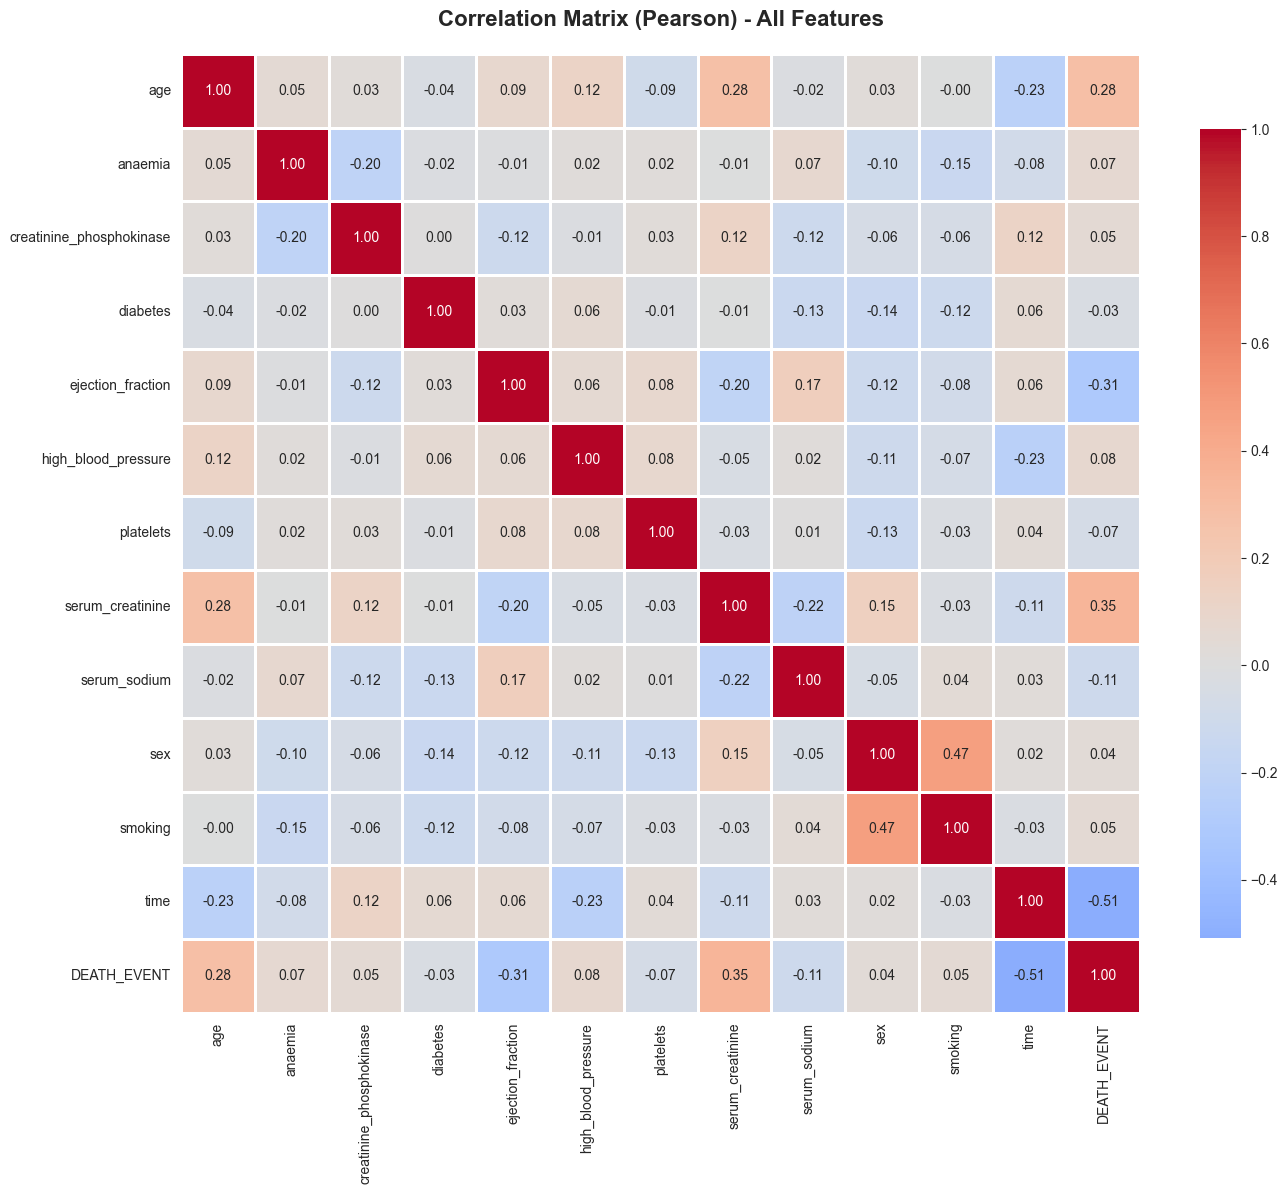

In [14]:
# Compute Pearson correlation matrix for all numeric features
correlation_matrix = df.corr(method='pearson')

# Create heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix (Pearson) - All Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


Correlations with DEATH_EVENT (sorted by absolute value):

serum_creatinine              :  0.349 (Moderate positive)
age                           :  0.282 (Weak positive)
high_blood_pressure           :  0.080 (Weak positive)
anaemia                       :  0.068 (Weak positive)
smoking                       :  0.051 (Weak positive)
creatinine_phosphokinase      :  0.049 (Weak positive)
sex                           :  0.037 (Weak positive)
diabetes                      : -0.032 (Weak negative)
platelets                     : -0.066 (Weak negative)
serum_sodium                  : -0.113 (Weak negative)
ejection_fraction             : -0.305 (Moderate negative)
time                          : -0.508 (Strong negative)


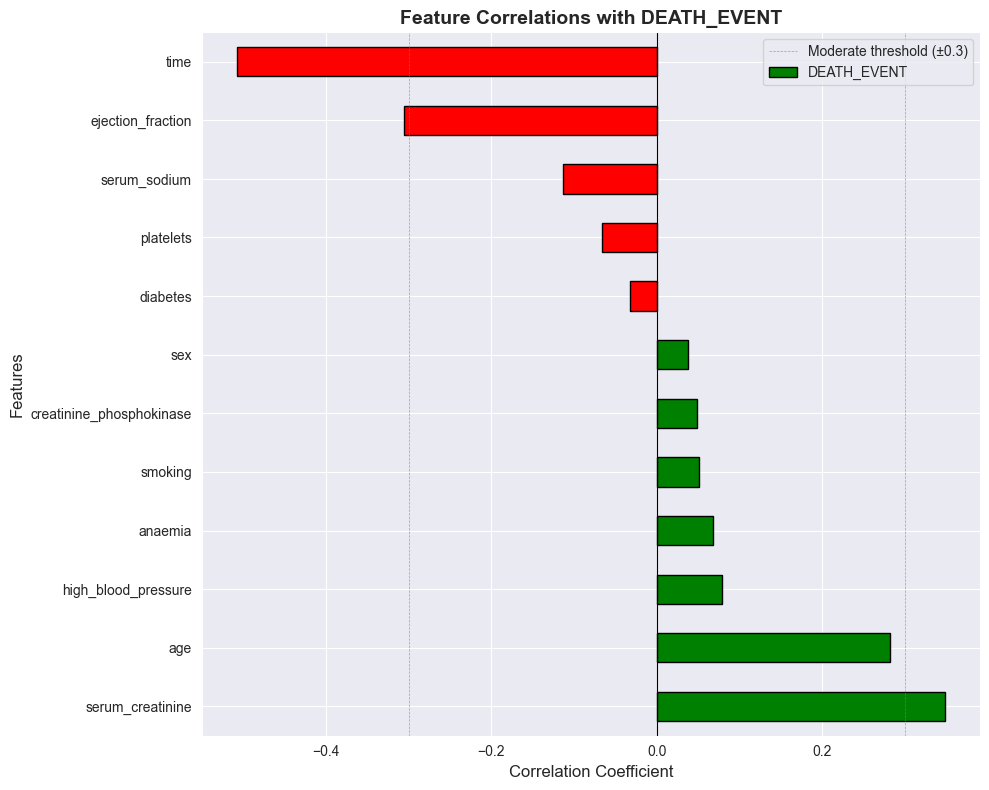

In [15]:
# Correlation with target variable (DEATH_EVENT)
target_corr = correlation_matrix['DEATH_EVENT'].drop('DEATH_EVENT').sort_values(ascending=False)

print("Correlations with DEATH_EVENT (sorted by absolute value):\n")
print("="*60)
for feature, corr_value in target_corr.items():
    strength = 'Strong' if abs(corr_value) > 0.5 else 'Moderate' if abs(corr_value) > 0.3 else 'Weak'
    direction = 'positive' if corr_value > 0 else 'negative'
    print(f"{feature:30s}: {corr_value:6.3f} ({strength} {direction})")

# Visualize correlations with DEATH_EVENT
plt.figure(figsize=(10, 8))
colors = ['red' if x < 0 else 'green' for x in target_corr.values]
target_corr.plot(kind='barh', color=colors, edgecolor='black')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Correlations with DEATH_EVENT', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.axvline(x=0.3, color='gray', linestyle='--', linewidth=0.5, alpha=0.7, label='Moderate threshold (±0.3)')
plt.axvline(x=-0.3, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# Check for multicollinearity among features (excluding target)
feature_corr = correlation_matrix.drop('DEATH_EVENT', axis=0).drop('DEATH_EVENT', axis=1)

# Find pairs with high correlation (potential multicollinearity)
print("\nHigh Feature-to-Feature Correlations (|r| > 0.5):")
print("="*60)
high_corr_pairs = []
for i in range(len(feature_corr.columns)):
    for j in range(i+1, len(feature_corr.columns)):
        if abs(feature_corr.iloc[i, j]) > 0.5:
            high_corr_pairs.append((feature_corr.columns[i], 
                                   feature_corr.columns[j], 
                                   feature_corr.iloc[i, j]))
            print(f"{feature_corr.columns[i]:30s} <-> {feature_corr.columns[j]:30s}: {feature_corr.iloc[i, j]:6.3f}")

if not high_corr_pairs:
    print("No strong feature-to-feature correlations detected (good - low multicollinearity)")
else:
    print(f"\nFound {len(high_corr_pairs)} pairs with potential multicollinearity")



High Feature-to-Feature Correlations (|r| > 0.5):
No strong feature-to-feature correlations detected (good - low multicollinearity)


### Note on PCA:

We did not apply PCA because the dataset contains only twelve features, all of which are clinically meaningful and interpretable. PCA is most useful for high-dimensional datasets or when features are highly correlated, neither of which applies here. Additionally, PCA removes interpretability by transforming predictors into abstract components, and several of our models (such as logistic regression with regularization and tree-based methods) already handle correlation and noise effectively without dimensionality reduction.
